# Investigate if adding residual layers help with output homogenuity?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader
from itertools import product
import pandas as pd
import seaborn as sns
import networkx as nx

In [3]:
import sys
import os
script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [4]:
from collab_env.data.file_utils import expand_path, get_project_root

In [5]:
from collab_env.gnn.gnn import get_adjcency_from_debug_batch, debug_result2prediction
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from collab_env.sim.boids_gnn_temp.animal_simulation import  static_visualize_2sets, visualize_graph_2sets
from scipy.stats import entropy
from figures.gnn.plot_helpers import plot_weighted_graph

### Load data!

In [6]:
data_names = ['boid_food_basic', 'boid_food_independent'] #'runpod/boid_single_species_basic']

# set short versions of dataset names
data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

In [7]:
datasets = load_various_data(data_names, 1, return_dict = True)

In [8]:
ablation = 0
all_combinations = [
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, ablation),
    # or ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
    #    if considering the noised version of the best seed that performed well noiseless
    #    results are the same
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4, ablation),
    #('boid_food_strong', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
]

In [10]:
ablation = 0
all_combinations = [
    ('boid_single_species_basic', 'GNNResidual', 0.005, 1, 0.5, 2, ablation),
    
    # or ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
    #    if considering the noised version of the best seed that performed well noiseless
    #    results are the same
    #('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4, ablation),
    #('boid_food_strong', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
]

In [11]:
rollout_results =  {}

model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = True
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation
    }
    
    data_name_short = data_names_short[data_name]
    if ablation:
        model_save_name = f'{model_name}\n{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}_ablation'
    else:
        model_save_name = f'{model_name}\n{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    
    #try:
        
    rollout_results[ind] = load_rollout(
            model_name, **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_GNNResidual_n0.005_h1_vr0.5_s2_rollout5.pkl
0, Successfully import GNNResidual
boid_
n0.005_h1_vr0.5_s2


### Get ground truth and predicted acceleration

In [22]:
m = 0
file_id = 10

In [23]:
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[m],
                    file_id = file_id, epoch_num = 0)


In [24]:
starting_frame = 0
ending_frame = 100

(0.0, 0.1)

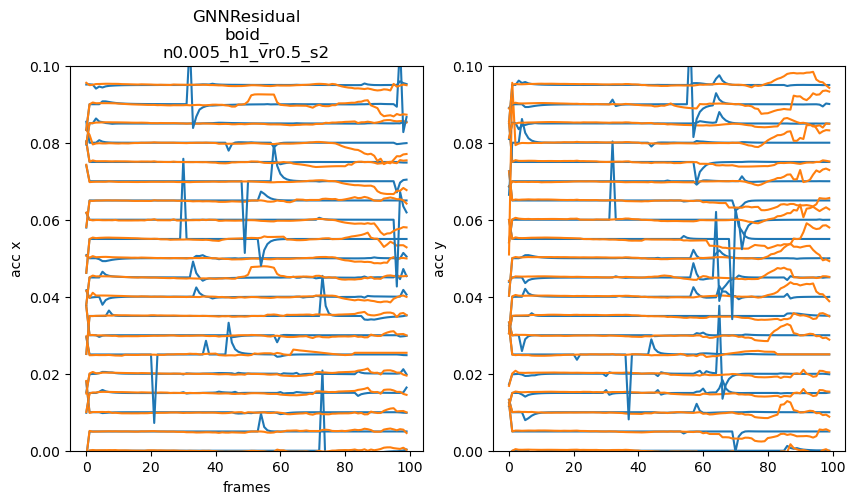

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for b in range(actual_acc.shape[2]):
    axes[0].plot(actual_acc[0,starting_frame:ending_frame,b,0] + 0.005 * b, color = 'C0')
    axes[1].plot(actual_acc[0,starting_frame:ending_frame,b,1] + 0.005 * b, color = 'C0')

    axes[0].plot(gnn_acc[0,starting_frame:ending_frame,b,0] + 0.005 * b, color = 'C1')
    axes[1].plot(gnn_acc[0,starting_frame:ending_frame,b,1] + 0.005 * b, color = 'C1')

axes[0].set_ylabel("acc x")
axes[0].set_xlabel("frames")

axes[1].set_ylabel("acc y")
axes[0].set_title(model_names[m])

axes[0].set_ylim([0, 0.1])
axes[1].set_ylim([0, 0.1])